## (GSE48213): Identifying gene expression patterns associated with different breast cancer subtypes

The dataset includes both treated (estrogen) and control conditions. 
We use Adaptive CCA to identify differences in gene expression patterns between these conditions over time.

The time points (1, 2, 4, 8, 12 hours) are not equally spaced, which is common in biological experiments. 
- Adaptive CCA should handle such non-linear time progressions 

In [2]:
import os
import pandas as pd
import numpy as np

file_path = os.path.join(os.getcwd(), "..", "data", "GSE48213")

In [3]:
os.getcwd()

'c:\\Users\\anaca\\Documents\\quinto.curso\\mitfg\\cca_manifolds\\ss24_CCA_Reduced_Rank\\src'

Dataset overview:

- 56 breast cancer cell lines were profiled
- The data represents gene expression levels in these cell lines
- Each cell line is in an unperturbed, baseline state


In current file: 

1. Column 1 (EnsEMBL_Gene_ID): unique identifier for each gene from the Ensembl database
2. Column 2 (e.g., MDAMB453): expression value for each gene in the specific cell line.

These are normalized read counts or FPKM/TPM values (Fragments/Transcripts Per Kilobase Million).
Higher values indicate higher expression of the gene in that cell line, zero values indicate that the gene is not expressed (or expression is below detection threshold)


In [4]:
from utils.utils import load_data
load_data(file_path, os.getcwd())

Index set to EnsEMBL_Gene_ID
Combined data has been saved to c:\Users\anaca\Documents\quinto.curso\mitfg\cca_manifolds\ss24_CCA_Reduced_Rank\src\combined_data.txt


,GSM1172844_184A1,GSM1172845_184B5,GSM1172846_21MT1,GSM1172847_21MT2,GSM1172848_21NT,GSM1172849_21PT,GSM1172850_600MPE,GSM1172851_AU565,GSM1172853_BT474,GSM1172854_BT483,GSM1172855_BT549,GSM1172856_CAMA1,GSM1172858_EFM192A,GSM1172859_EFM192B,GSM1172860_EFM192C,GSM1172861_HCC1143,GSM1172863_HCC1395,GSM1172864_HCC1419,GSM1172865_HCC1428,GSM1172906_UACC812,GSM1172907_UACC893,GSM1172908_ZR751,GSM1172909_ZR7530,GSM1172910_ZR75B,GSM1384316_MDAMB453
EnsEMBL_Gene_ID,,,,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,95.212548,95.698676,19.994674,65.686376,44.057746,34.317565,178.158832,13.460144,37.879666,69.092581,129.384759,21.159890,19.098331,16.248046,1.139480,216.930143,96.785401,6.847876,43.965782,26.579280,50.676579,31.812999,121.459918,2.293898,2.025956
ENSG00000001167,89.512619,94.154375,245.433541,216.487072,286.092419,289.298295,125.193255,68.907655,167.815672,152.752421,291.459218,381.134947,103.535326,112.971577,80.855074,285.900419,347.992398,98.756895,162.757442,138.140311,106.342032,68.458022,73.910964,61.625519,136.161392
ENSG00000005471,0.000000,0.172734,0.231762,0.099938,0.000000,0.000000,0.757785,2.976117,1.210384,1.670807,0.000000,0.880168,3.824066,1.225034,1.920000,0.000000,0.054333,2.402739,2.713846,0.440649,0.066213,0.548865,0.611036,0.556531,0.087010
ENSG00000066629,24.701397,7.633869,5.842132,6.773438,5.149179,7.432176,29.604076,15.084108,30.669290,135.100074,30.938071,4.334134,60.148970,101.360150,114.044656,16.952487,97.143133,34.884041,79.282346,79.187879,0.058835,25.493800,25.917323,32.528112,0.000000
ENSG00000154258,0.000000,2.683498,0.000000,0.031877,0.000000,0.000000,0.652424,0.000000,0.065451,0.000000,0.000000,0.031240,0.000000,0.000000,0.068119,0.102304,0.207510,0.097948,0.000000,0.040907,0.021120,0.000000,0.033571,0.177808,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000154229,50.153014,6.307886,73.198238,45.283423,91.826948,94.667006,4.835407,51.196873,18.660523,1.271292,242.366506,3.842701,0.089655,0.237638,0.047993,51.165867,80.279190,1.276649,1.676753,14.153042,16.090697,6.794076,12.442838,10.691891,2.490993
ENSG00000154237,51.372615,19.782605,39.113584,50.052251,28.074873,30.620917,4.591209,3.121563,1.780330,5.195107,16.288214,0.838128,38.027899,43.721240,37.653589,38.674515,2.983126,33.744973,4.347457,4.693441,10.134877,21.428970,41.384456,13.321714,3.255213
ENSG00000154240,14.735200,5.071096,1.690885,0.521761,1.303221,0.930950,10.099978,0.222417,1.264567,0.846007,6.926540,0.760935,0.000000,0.389956,0.000000,48.908626,2.149875,0.000000,0.689206,4.954351,0.447181,3.717654,2.425406,4.566561,0.000000


In [5]:
output_file = os.path.join(os.getcwd(), "combined_data.txt")
data = pd.read_csv(output_file, sep="\t")

In [6]:
data.head()

,EnsEMBL_Gene_ID,GSM1172844_184A1,GSM1172845_184B5,GSM1172846_21MT1,GSM1172847_21MT2,GSM1172848_21NT,GSM1172849_21PT,GSM1172850_600MPE,GSM1172851_AU565,GSM1172853_BT474,GSM1172854_BT483,GSM1172855_BT549,GSM1172856_CAMA1,GSM1172858_EFM192A,GSM1172859_EFM192B,GSM1172860_EFM192C,GSM1172861_HCC1143,GSM1172863_HCC1395,GSM1172864_HCC1419,GSM1172865_HCC1428,GSM1172906_UACC812,GSM1172907_UACC893,GSM1172908_ZR751,GSM1172909_ZR7530,GSM1172910_ZR75B,GSM1384316_MDAMB453
0,ENSG00000000003,95.212548,95.698676,19.994674,65.686376,44.057746,34.317565,178.158832,13.460144,37.879666,69.092581,129.384759,21.159890,19.098331,16.248046,1.139480,216.930143,96.785401,6.847876,43.965782,26.579280,50.676579,31.812999,121.459918,2.293898,2.025956
1,ENSG00000001167,89.512619,94.154375,245.433541,216.487072,286.092419,289.298295,125.193255,68.907655,167.815672,152.752421,291.459218,381.134947,103.535326,112.971577,80.855074,285.900419,347.992398,98.756895,162.757442,138.140311,106.342032,68.458022,73.910964,61.625519,136.161392
2,ENSG00000005471,0.000000,0.172734,0.231762,0.099938,0.000000,0.000000,0.757785,2.976117,1.210384,1.670807,0.000000,0.880168,3.824066,1.225034,1.920000,0.000000,0.054333,2.402739,2.713846,0.440649,0.066213,0.548865,0.611036,0.556531,0.087010
3,ENSG00000066629,24.701397,7.633869,5.842132,6.773438,5.149179,7.432176,29.604076,15.084108,30.669290,135.100074,30.938071,4.334134,60.148970,101.360150,114.044656,16.952487,97.143133,34.884041,79.282346,79.187879,0.058835,25.493800,25.917323,32.528112,0.000000
4,ENSG00000154258,0.000000,2.683498,0.000000,0.031877,0.000000,0.000000,0.652424,0.000000,0.065451,0.000000,0.000000,0.031240,0.000000,0.000000,0.068119,0.102304,0.207510,0.097948,0.000000,0.040907,0.021120,0.000000,0.033571,0.177808,0.000000


In [7]:
data.columns


Index(['EnsEMBL_Gene_ID', 'GSM1172844_184A1', 'GSM1172845_184B5',
       'GSM1172846_21MT1', 'GSM1172847_21MT2', 'GSM1172848_21NT',
       'GSM1172849_21PT', 'GSM1172850_600MPE', 'GSM1172851_AU565',
       'GSM1172853_BT474', 'GSM1172854_BT483', 'GSM1172855_BT549',
       'GSM1172856_CAMA1', 'GSM1172858_EFM192A', 'GSM1172859_EFM192B',
       'GSM1172860_EFM192C', 'GSM1172861_HCC1143', 'GSM1172863_HCC1395',
       'GSM1172864_HCC1419', 'GSM1172865_HCC1428', 'GSM1172906_UACC812',
       'GSM1172907_UACC893', 'GSM1172908_ZR751', 'GSM1172909_ZR7530',
       'GSM1172910_ZR75B', 'GSM1384316_MDAMB453'],
      dtype='object')

#### Preprocessing: Log2 Transformation
Gene expression values vary too much across genes and cell lines, with some genes having very high expression values and others having very low ones (sometimes even zero). This creates a skewed distribution. A log2 transformation helps to normalize this range and make the data more comparable across genes and cell lines.
- without log transformation, highly expressed genes dominate the analysis, hiding patterns in the data for moderately or lowly expressed genes.

In [8]:
# ---------- PREPROCESSING ----------  #
from preprocessing import log2_transform, classify

log2_data = log2_transform(data)
classify(log2_data)


                          Subtype
EnsEMBL_Gene_ID      Unclassified
GSM1172844_184A1     Unclassified
GSM1172845_184B5     Unclassified
GSM1172846_21MT1     Unclassified
GSM1172847_21MT2     Unclassified
GSM1172848_21NT      Unclassified
GSM1172849_21PT      Unclassified
GSM1172850_600MPE    Unclassified
GSM1172851_AU565     Unclassified
GSM1172853_BT474     Unclassified
GSM1172854_BT483     Unclassified
GSM1172855_BT549     Unclassified
GSM1172856_CAMA1     Unclassified
GSM1172858_EFM192A   Unclassified
GSM1172859_EFM192B   Unclassified
GSM1172860_EFM192C   Unclassified
GSM1172861_HCC1143   Unclassified
GSM1172863_HCC1395   Unclassified
GSM1172864_HCC1419   Unclassified
GSM1172865_HCC1428   Unclassified
GSM1172906_UACC812   Unclassified
GSM1172907_UACC893   Unclassified
GSM1172908_ZR751        Luminal A
GSM1172909_ZR7530       Luminal A
GSM1172910_ZR75B        Luminal A
GSM1384316_MDAMB453  Unclassified

One-hot encoded subtypes:
                     Luminal A  Unclassified
EnsEMBL_Ge

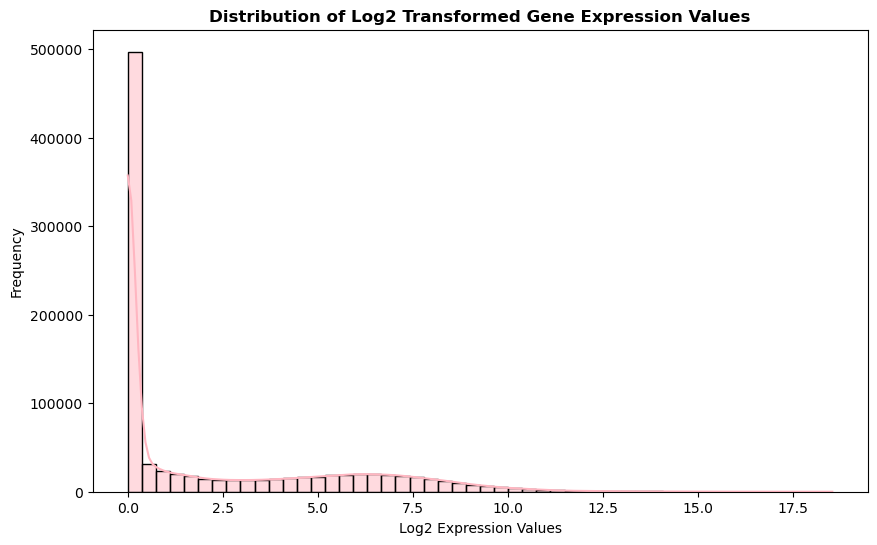

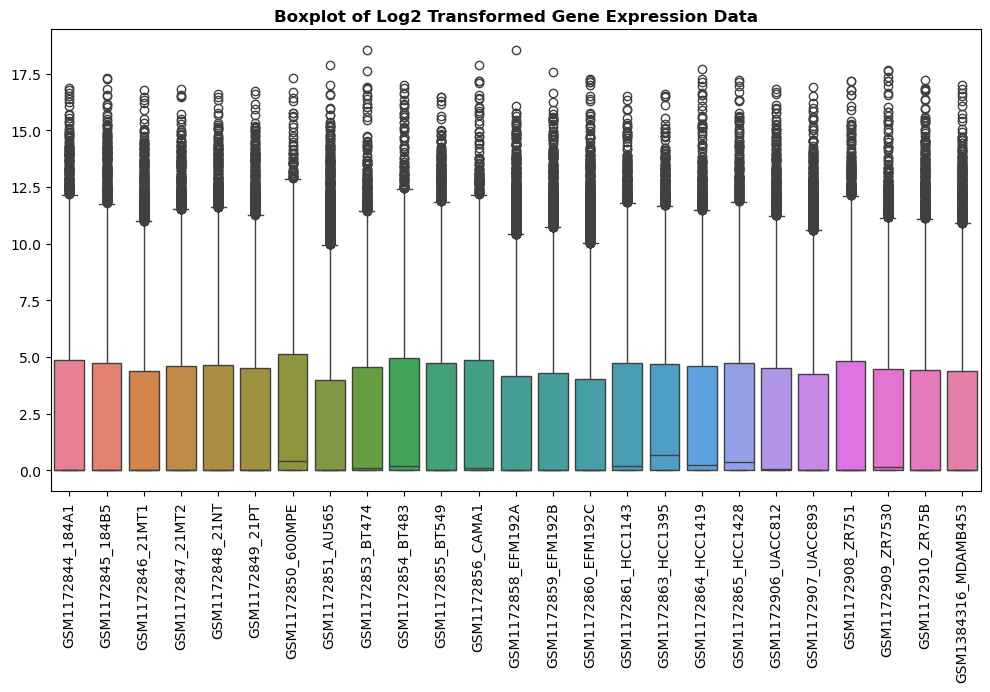

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(log2_transformed_data: pd.DataFrame):
    """
    Plots the distribution of log2 transformed gene expression data.
    
    Arguments:
    - log2_transformed_data: DataFrame with the log2 transformed gene expression values.
    """
    # Exclude the gene ID column
    expression_data = log2_transformed_data.iloc[:, 1:]
    
    # Histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(expression_data.values.flatten(), bins=50, kde=True, color='lightpink')
    # make title bold
    plt.title('Distribution of Log2 Transformed Gene Expression Values', fontweight='bold')
    plt.xlabel('Log2 Expression Values')
    plt.ylabel('Frequency')
    plt.show()

    # Plot boxplot for each cell line
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=expression_data)
    plt.xticks(rotation=90)
    plt.title('Boxplot of Log2 Transformed Gene Expression Data', fontweight='bold')
    plt.show()

plot_distribution(log2_data)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Heatmap of gene expression across cell lines
plt.figure(figsize=(12, 8))
sns.heatmap(data_scaled.iloc[:100, :], cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Heatmap of Gene Expression (First 100 Genes)')
plt.show()

# Distribution of gene expression values
plt.figure(figsize=(10, 6))
data_scaled.mean().hist(bins=50)
plt.title('Distribution of Mean Gene Expression Across Cell Lines')
plt.xlabel('Mean Expression')
plt.ylabel('Frequency')
plt.show()

# PCA plot
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled.T)
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
for i, cell_line in enumerate(data_scaled.columns):
    plt.annotate(cell_line, (pca_result[i, 0], pca_result[i, 1]))
plt.title('PCA of Cell Lines')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Correlation between cell lines
correlation = data_scaled.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='coolwarm', center=0)
plt.title('Correlation Between Cell Lines')
plt.show()


NameError: name 'data_scaled' is not defined

<Figure size 1200x800 with 0 Axes>